In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


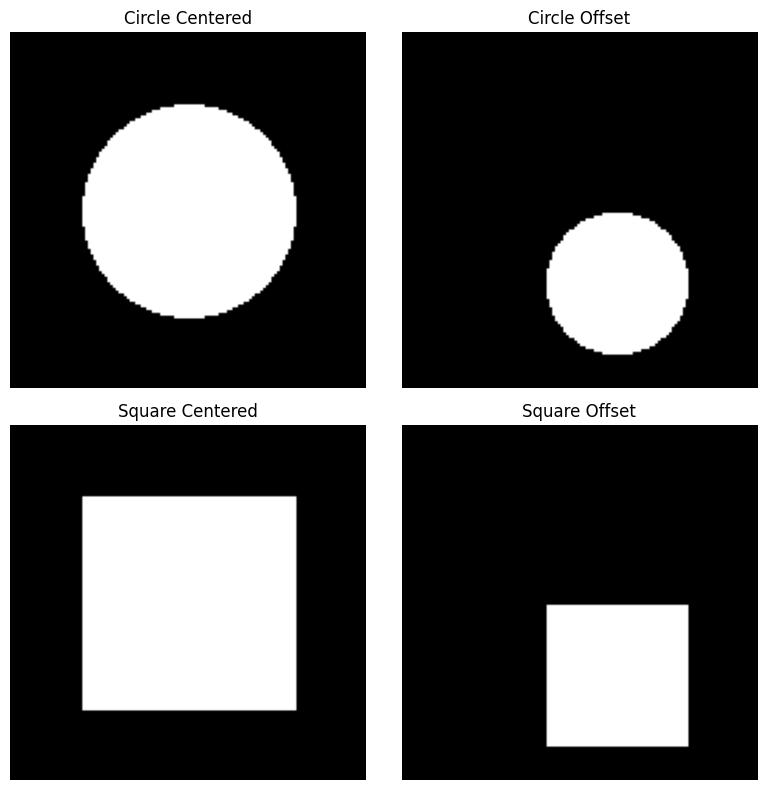

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from core.linalg_utils import circular_aperture, square_aperture

# テスト用画像サイズ
shape = (128, 128)

# 半径の正規化スケールでの指定
r = 0.3

# 原点中心（デフォルト）
circle_mask = circular_aperture(shape, radius=r)
square_mask = square_aperture(shape, radius=r)

# 原点からずらした中心 (0.1, -0.2)
offset_center = (0.1, -0.2)
circle_offset = circular_aperture(shape, radius=0.2, center=offset_center)
square_offset = square_aperture(shape, radius=0.2, center=offset_center)

# 可視化
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(circle_mask, cmap="gray")
axs[0, 0].set_title("Circle Centered")

axs[0, 1].imshow(circle_offset, cmap="gray")
axs[0, 1].set_title("Circle Offset")

axs[1, 0].imshow(square_mask, cmap="gray")
axs[1, 0].set_title("Square Centered")

axs[1, 1].imshow(square_offset, cmap="gray")
axs[1, 1].set_title("Square Offset")

for ax in axs.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


[t=0] MSE = 1.99152e-04
[t=5] MSE = 5.58701e-05
[t=10] MSE = 5.58701e-05
[t=15] MSE = 5.58701e-05
[t=20] MSE = 5.58701e-05
[t=25] MSE = 5.58701e-05


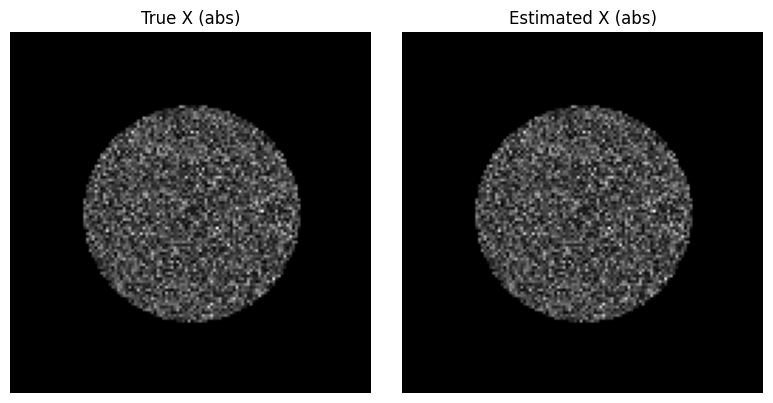

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from core.metrics import mse
from core.linalg_utils import circular_aperture, random_phase_mask, random_binary_mask
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.gaussian_measurement import GaussianMeasurement

# ==== 1. パラメータ設定 ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
mask_ratio = 0.2
support_radius = 0.3
rng = np.random.default_rng(seed=42)

# ==== 2. グラフ定義 ====
class SupportPriorCSGraph(Graph):
    def __init__(self):
        super().__init__()

        # 2.1 Support mask
        support = circular_aperture(shape, radius=support_radius)
        self.X = SupportPrior(support=support, scalar_precision=False)

        # 2.2 Forward model
        phase_mask = random_phase_mask(shape, rng=rng)
        self.Y = PhaseMaskPropagator(phase_mask) @ self.X
        self.F = FFT2DPropagator(shape=shape) @ self.Y
        self.Z = GaussianMeasurement(self.F, var=var)

        #2.3 compile
        self.compile()

# ==== 3. 推論実行 ====
g = SupportPriorCSGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=11))

true_x = g.X.get_sample()

def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = mse(est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

g.run(n_iter=30, callback=monitor)

# ==== 4. 可視化 ====
final_est = g.X.compute_belief().data

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("True X (abs)")
plt.imshow(np.abs(true_x), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Estimated X (abs)")
plt.imshow(np.abs(final_est), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
